In [1]:
pip install torch torchvision torchaudio

  Using cached typing_extensions-4.12.2-py3-none-any.whl.metadata (3.0 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.3/64.3 MB 31.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 39.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 30.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 33.0 MB/s eta 0:00:00
Using cached typing_extensions-4.12.2-py3-none-any.whl (37 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 30.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.2/536.2 kB 21.0 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.7.1
    Uninstalling typing_extensions-4.7.1:
      Successfully uninstalled typing_extensions-4.7.1
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install numpy pandas matplotlib tqdm scikit-learn torchinfo jupyter

Note: you may need to restart the kernel to use updated packages.


In [3]:
!python -c "import torch; print(torch.__version__); print(torch.cuda.is_available())"

Traceback (most recent call last):
  File "<string>", line 1, in <module>
ModuleNotFoundError: No module named 'torch'


In [4]:
import os
import requests
import zipfile

# 定义数据的URL和路径
data_url = 'https://raw.githubusercontent.com/zcakhaa/DeepLOB-Deep-Convolutional-Neural-Networks-for-Limit-Order-Books/master/data/data.zip'
data_zip_path = 'data.zip'
data_folder = 'data'  # 解压后的文件夹名称

# 检查 data.zip 是否存在
if not os.path.isfile(data_zip_path):
    print('正在下载数据...')
    response = requests.get(data_url, stream=True)
    with open(data_zip_path, 'wb') as f:
        for chunk in response.iter_content(chunk_size=1024):
            if chunk:
                f.write(chunk)
    print('数据下载完成。')

    # 解压 data.zip
    print('正在解压数据...')
    with zipfile.ZipFile(data_zip_path, 'r') as zip_ref:
        zip_ref.extractall('.')
    print('数据解压完成。')
else:
    print('data.zip 已存在。')
    # 检查解压后的文件夹是否存在
    if not os.path.exists(data_folder):
        print('正在解压数据...')
        with zipfile.ZipFile(data_zip_path, 'r') as zip_ref:
            zip_ref.extractall('.')
        print('数据解压完成。')
    else:
        print('数据已解压。')

正在下载数据...
数据下载完成。
正在解压数据...
数据解压完成。


In [5]:
# load packages
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from tqdm import tqdm 
from sklearn.metrics import accuracy_score, classification_report

import torch
import torch.nn.functional as F
from torch.utils import data
from torchinfo import summary
import torch.nn as nn
import torch.optim as optim
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(data.data, data.target, test_size=0.33)
# N, D = X_train.shape

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [7]:
def prepare_x(data):
    df1 = data[:40, :].T
    return np.array(df1)

def get_label(data):
    lob = data[-5:, :].T
    return lob

def data_classification(X, Y, T):
    [N, D] = X.shape
    df = np.array(X)

    dY = np.array(Y)

    dataY = dY[T - 1:N]

    dataX = np.zeros((N - T + 1, T, D))
    for i in range(T, N + 1):
        dataX[i - T] = df[i - T:i, :]

    return dataX, dataY

def torch_data(x, y):
    x = torch.from_numpy(x)
    x = torch.unsqueeze(x, 1)
    y = torch.from_numpy(y)
    y = F.one_hot(y, num_classes=3)
    return x, y

In [8]:
class Dataset(data.Dataset):
    """Characterizes a dataset for PyTorch"""
    def __init__(self, data, k, num_classes, T):
        """Initialization""" 
        self.k = k
        self.num_classes = num_classes
        self.T = T
            
        x = prepare_x(data)
        y = get_label(data)
        x, y = data_classification(x, y, self.T)
        y = y[:,self.k] - 1
        self.length = len(x)

        x = torch.from_numpy(x)
        self.x = torch.unsqueeze(x, 1)
        self.y = torch.from_numpy(y)

    def __len__(self):
        """Denotes the total number of samples"""
        return self.length

    def __getitem__(self, index):
        """Generates samples of data"""
        return self.x[index], self.y[index]

In [9]:
# please change the data_path to your local path
# data_path = '/nfs/home/zihaoz/limit_order_book/data'

dec_data = np.loadtxt('Train_Dst_NoAuction_DecPre_CF_7.txt')
dec_train = dec_data[:, :int(np.floor(dec_data.shape[1] * 0.8))]
dec_val = dec_data[:, int(np.floor(dec_data.shape[1] * 0.8)):]

dec_test1 = np.loadtxt('Test_Dst_NoAuction_DecPre_CF_7.txt')
dec_test2 = np.loadtxt('Test_Dst_NoAuction_DecPre_CF_8.txt')
dec_test3 = np.loadtxt('Test_Dst_NoAuction_DecPre_CF_9.txt')
dec_test = np.hstack((dec_test1, dec_test2, dec_test3))

print(dec_train.shape, dec_val.shape, dec_test.shape)

(149, 203800) (149, 50950) (149, 139587)


In [10]:
batch_size = 64

dataset_train = Dataset(data=dec_train, k=4, num_classes=3, T=100)
dataset_val = Dataset(data=dec_val, k=4, num_classes=3, T=100)
dataset_test = Dataset(data=dec_test, k=4, num_classes=3, T=100)

train_loader = torch.utils.data.DataLoader(dataset=dataset_train, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=dataset_val, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=dataset_test, batch_size=batch_size, shuffle=False)

print(dataset_train.x.shape, dataset_train.y.shape)

torch.Size([203701, 1, 100, 40]) torch.Size([203701])


In [11]:
tmp_loader = torch.utils.data.DataLoader(dataset=dataset_train, batch_size=1, shuffle=True)

for x, y in tmp_loader:
    print(x)
    print(y)
    print(x.shape, y.shape)
    break

tensor([[[[0.1238, 0.0165, 0.1237,  ..., 0.0250, 0.1228, 0.0380],
          [0.1238, 0.0373, 0.1237,  ..., 0.0250, 0.1228, 0.0380],
          [0.1238, 0.0504, 0.1237,  ..., 0.0250, 0.1228, 0.0380],
          ...,
          [0.1241, 0.0213, 0.1237,  ..., 0.0363, 0.1228, 0.0289],
          [0.1241, 0.0277, 0.1237,  ..., 0.0363, 0.1228, 0.0289],
          [0.1241, 0.0258, 0.1237,  ..., 0.0363, 0.1228, 0.0289]]]],
       dtype=torch.float64)
tensor([0.], dtype=torch.float64)
torch.Size([1, 1, 100, 40]) torch.Size([1])


In [12]:
class deeplob(nn.Module):
    def __init__(self, y_len):
        super().__init__()
        self.y_len = y_len
        
        # convolution blocks
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(1,2), stride=(1,2)),
            nn.LeakyReLU(negative_slope=0.01),
#             nn.Tanh(),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4,1)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4,1)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(32),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(1,2), stride=(1,2)),
            nn.Tanh(),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4,1)),
            nn.Tanh(),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4,1)),
            nn.Tanh(),
            nn.BatchNorm2d(32),
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(1,10)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4,1)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4,1)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(32),
        )
        
        # inception moduels
        self.inp1 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(1,1), padding='same'),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3,1), padding='same'),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(64),
        )
        self.inp2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(1,1), padding='same'),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(5,1), padding='same'),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(64),
        )
        self.inp3 = nn.Sequential(
            nn.MaxPool2d((3, 1), stride=(1, 1), padding=(1, 0)),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(1,1), padding='same'),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(64),
        )
        
        # lstm layers
        self.lstm = nn.LSTM(input_size=192, hidden_size=64, num_layers=1, batch_first=True)
        self.fc1 = nn.Linear(64, self.y_len)

    def forward(self, x):
        # h0: (number of hidden layers, batch size, hidden size)
        h0 = torch.zeros(1, x.size(0), 64).to(device)
        c0 = torch.zeros(1, x.size(0), 64).to(device)
    
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        
        x_inp1 = self.inp1(x)
        x_inp2 = self.inp2(x)
        x_inp3 = self.inp3(x)  
        
        x = torch.cat((x_inp1, x_inp2, x_inp3), dim=1)
        
#         x = torch.transpose(x, 1, 2)
        x = x.permute(0, 2, 1, 3)
        x = torch.reshape(x, (-1, x.shape[1], x.shape[2]))
        
        x, _ = self.lstm(x, (h0, c0))
        x = x[:, -1, :]
        x = self.fc1(x)
        forecast_y = torch.softmax(x, dim=1)
        
        return forecast_y

In [13]:
model = deeplob(y_len = dataset_train.num_classes)
model.to(device)

deeplob(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(1, 2), stride=(1, 2))
    (1): LeakyReLU(negative_slope=0.01)
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(4, 1), stride=(1, 1))
    (4): LeakyReLU(negative_slope=0.01)
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(32, 32, kernel_size=(4, 1), stride=(1, 1))
    (7): LeakyReLU(negative_slope=0.01)
    (8): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(1, 2), stride=(1, 2))
    (1): Tanh()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(4, 1), stride=(1, 1))
    (4): Tanh()
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(32, 32, kernel_size=(4, 1), stride

In [14]:
summary(model, (1, 1, 100, 40))

Layer (type:depth-idx)                   Output Shape              Param #
deeplob                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 32, 94, 20]           --
│    └─Conv2d: 2-1                       [1, 32, 100, 20]          96
│    └─LeakyReLU: 2-2                    [1, 32, 100, 20]          --
│    └─BatchNorm2d: 2-3                  [1, 32, 100, 20]          64
│    └─Conv2d: 2-4                       [1, 32, 97, 20]           4,128
│    └─LeakyReLU: 2-5                    [1, 32, 97, 20]           --
│    └─BatchNorm2d: 2-6                  [1, 32, 97, 20]           64
│    └─Conv2d: 2-7                       [1, 32, 94, 20]           4,128
│    └─LeakyReLU: 2-8                    [1, 32, 94, 20]           --
│    └─BatchNorm2d: 2-9                  [1, 32, 94, 20]           64
├─Sequential: 1-2                        [1, 32, 88, 10]           --
│    └─Conv2d: 2-10                      [1, 32, 94, 10]           2,080
│    └

In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

## Model Training

In [16]:
# A function to encapsulate the training loop
def batch_gd(model, criterion, optimizer, train_loader, test_loader, epochs):
    
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)
    best_test_loss = np.inf
    best_test_epoch = 0

    for it in tqdm(range(epochs)):
        
        model.train()
        t0 = datetime.now()
        train_loss = []
        for inputs, targets in train_loader:
            # move data to GPU
            inputs, targets = inputs.to(device, dtype=torch.float), targets.to(device, dtype=torch.int64)
            # print("inputs.shape:", inputs.shape)
            # zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass
            # print("about to get model output")
            outputs = model(inputs)
            # print("done getting model output")
            # print("outputs.shape:", outputs.shape, "targets.shape:", targets.shape)
            loss = criterion(outputs, targets)
            # Backward and optimize
            # print("about to optimize")
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
        # Get train loss and test loss
        train_loss = np.mean(train_loss) # a little misleading
    
        model.eval()
        test_loss = []
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device, dtype=torch.float), targets.to(device, dtype=torch.int64)      
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss.append(loss.item())
        test_loss = np.mean(test_loss)

        # Save losses
        train_losses[it] = train_loss
        test_losses[it] = test_loss
        
        if test_loss < best_test_loss:
            torch.save(model, './best_val_model_pytorch')
            best_test_loss = test_loss
            best_test_epoch = it
            print('model saved')

        dt = datetime.now() - t0
        print(f'Epoch {it+1}/{epochs}, Train Loss: {train_loss:.4f}, \
          Validation Loss: {test_loss:.4f}, Duration: {dt}, Best Val Epoch: {best_test_epoch}')

    return train_losses, test_losses

In [17]:
train_losses, val_losses = batch_gd(model, criterion, optimizer, 
                                    train_loader, val_loader, epochs=50)

  2%|▏         | 1/50 [21:32<17:35:44, 1292.74s/it]

model saved
Epoch 1/50, Train Loss: 0.9188,           Validation Loss: 0.9718, Duration: 0:21:32.742541, Best Val Epoch: 0


  4%|▍         | 2/50 [43:05<17:14:21, 1292.95s/it]

model saved
Epoch 2/50, Train Loss: 0.8218,           Validation Loss: 0.9597, Duration: 0:21:33.082747, Best Val Epoch: 1


  6%|▌         | 3/50 [1:03:42<16:32:47, 1267.40s/it]

Epoch 3/50, Train Loss: 0.7928,           Validation Loss: 1.0345, Duration: 0:20:36.992241, Best Val Epoch: 1


  8%|▊         | 4/50 [1:24:08<15:59:11, 1251.11s/it]

model saved
Epoch 4/50, Train Loss: 0.7752,           Validation Loss: 0.9571, Duration: 0:20:26.149376, Best Val Epoch: 3


 10%|█         | 5/50 [1:44:26<15:29:20, 1239.11s/it]

model saved
Epoch 5/50, Train Loss: 0.7626,           Validation Loss: 0.9274, Duration: 0:20:17.835619, Best Val Epoch: 4


 12%|█▏        | 6/50 [2:04:48<15:04:23, 1233.26s/it]

model saved
Epoch 6/50, Train Loss: 0.7538,           Validation Loss: 0.8876, Duration: 0:20:21.882621, Best Val Epoch: 5


 14%|█▍        | 7/50 [2:25:05<14:39:53, 1227.76s/it]

Epoch 7/50, Train Loss: 0.7460,           Validation Loss: 0.8883, Duration: 0:20:16.456163, Best Val Epoch: 5


 16%|█▌        | 8/50 [2:45:35<14:20:07, 1228.74s/it]

Epoch 8/50, Train Loss: 0.7400,           Validation Loss: 0.8991, Duration: 0:20:30.822828, Best Val Epoch: 5


 18%|█▊        | 9/50 [3:07:11<14:13:54, 1249.62s/it]

model saved
Epoch 9/50, Train Loss: 0.7341,           Validation Loss: 0.8780, Duration: 0:21:35.527479, Best Val Epoch: 8


 20%|██        | 10/50 [3:28:51<14:03:26, 1265.15s/it]

Epoch 10/50, Train Loss: 0.7283,           Validation Loss: 0.8813, Duration: 0:21:39.940018, Best Val Epoch: 8


 22%|██▏       | 11/50 [3:50:38<13:50:45, 1278.10s/it]

Epoch 11/50, Train Loss: 0.7233,           Validation Loss: 0.8870, Duration: 0:21:47.436724, Best Val Epoch: 8


 24%|██▍       | 12/50 [4:13:43<13:49:54, 1310.39s/it]

model saved
Epoch 12/50, Train Loss: 0.7181,           Validation Loss: 0.8749, Duration: 0:23:04.249765, Best Val Epoch: 11


 26%|██▌       | 13/50 [4:37:14<13:47:00, 1341.09s/it]

Epoch 13/50, Train Loss: 0.7132,           Validation Loss: 0.8966, Duration: 0:23:31.734976, Best Val Epoch: 11


 28%|██▊       | 14/50 [5:01:35<13:46:21, 1377.25s/it]

Epoch 14/50, Train Loss: 0.7091,           Validation Loss: 0.8944, Duration: 0:24:20.809060, Best Val Epoch: 11


 30%|███       | 15/50 [5:24:22<13:21:34, 1374.13s/it]

Epoch 15/50, Train Loss: 0.7059,           Validation Loss: 0.8872, Duration: 0:22:46.892333, Best Val Epoch: 11


 32%|███▏      | 16/50 [5:47:24<13:00:04, 1376.60s/it]

Epoch 16/50, Train Loss: 0.7027,           Validation Loss: 0.8842, Duration: 0:23:02.333178, Best Val Epoch: 11


 34%|███▍      | 17/50 [6:10:27<12:38:07, 1378.41s/it]

Epoch 17/50, Train Loss: 0.6989,           Validation Loss: 0.8920, Duration: 0:23:02.627952, Best Val Epoch: 11


 36%|███▌      | 18/50 [6:33:24<12:14:51, 1377.86s/it]

Epoch 18/50, Train Loss: 0.6966,           Validation Loss: 0.8831, Duration: 0:22:56.559703, Best Val Epoch: 11


 38%|███▊      | 19/50 [6:56:25<11:52:24, 1378.86s/it]

Epoch 19/50, Train Loss: 0.6935,           Validation Loss: 0.8868, Duration: 0:23:01.203368, Best Val Epoch: 11


 40%|████      | 20/50 [7:19:23<11:29:22, 1378.76s/it]

Epoch 20/50, Train Loss: 0.6912,           Validation Loss: 0.8978, Duration: 0:22:58.529315, Best Val Epoch: 11


 42%|████▏     | 21/50 [7:42:22<11:06:23, 1378.73s/it]

Epoch 21/50, Train Loss: 0.6889,           Validation Loss: 0.8921, Duration: 0:22:58.659259, Best Val Epoch: 11


 44%|████▍     | 22/50 [8:05:20<10:43:18, 1378.53s/it]

Epoch 22/50, Train Loss: 0.6862,           Validation Loss: 0.8835, Duration: 0:22:58.063612, Best Val Epoch: 11


 46%|████▌     | 23/50 [8:28:18<10:20:16, 1378.38s/it]

Epoch 23/50, Train Loss: 0.6843,           Validation Loss: 0.8822, Duration: 0:22:58.018977, Best Val Epoch: 11


 48%|████▊     | 24/50 [8:51:05<9:55:47, 1374.91s/it] 

Epoch 24/50, Train Loss: 0.6817,           Validation Loss: 0.8961, Duration: 0:22:46.832019, Best Val Epoch: 11


 50%|█████     | 25/50 [9:13:07<9:26:13, 1358.95s/it]

Epoch 25/50, Train Loss: 0.6799,           Validation Loss: 0.8907, Duration: 0:22:01.689930, Best Val Epoch: 11


 52%|█████▏    | 26/50 [9:35:59<9:05:09, 1362.88s/it]

Epoch 26/50, Train Loss: 0.6780,           Validation Loss: 0.9025, Duration: 0:22:52.046338, Best Val Epoch: 11


 54%|█████▍    | 27/50 [9:58:46<8:42:56, 1364.20s/it]

Epoch 27/50, Train Loss: 0.6771,           Validation Loss: 0.8835, Duration: 0:22:47.270651, Best Val Epoch: 11


 56%|█████▌    | 28/50 [10:20:45<8:15:13, 1350.61s/it]

Epoch 28/50, Train Loss: 0.6749,           Validation Loss: 0.8874, Duration: 0:21:58.923660, Best Val Epoch: 11


 58%|█████▊    | 29/50 [10:42:48<7:49:47, 1342.27s/it]

Epoch 29/50, Train Loss: 0.6738,           Validation Loss: 0.8871, Duration: 0:22:02.804108, Best Val Epoch: 11


 60%|██████    | 30/50 [11:04:44<7:24:52, 1334.62s/it]

Epoch 30/50, Train Loss: 0.6718,           Validation Loss: 0.8867, Duration: 0:21:56.750651, Best Val Epoch: 11


 62%|██████▏   | 31/50 [11:26:45<7:01:19, 1330.50s/it]

Epoch 31/50, Train Loss: 0.6706,           Validation Loss: 0.8929, Duration: 0:22:00.907558, Best Val Epoch: 11


 64%|██████▍   | 32/50 [11:49:26<6:41:50, 1339.45s/it]

Epoch 32/50, Train Loss: 0.6692,           Validation Loss: 0.8963, Duration: 0:22:40.332200, Best Val Epoch: 11


 66%|██████▌   | 33/50 [12:12:22<6:22:40, 1350.65s/it]

Epoch 33/50, Train Loss: 0.6682,           Validation Loss: 0.8905, Duration: 0:22:56.759517, Best Val Epoch: 11


 68%|██████▊   | 34/50 [12:35:09<6:01:25, 1355.32s/it]

Epoch 34/50, Train Loss: 0.6672,           Validation Loss: 0.8917, Duration: 0:22:46.226279, Best Val Epoch: 11


 70%|███████   | 35/50 [12:57:40<5:38:34, 1354.27s/it]

Epoch 35/50, Train Loss: 0.6666,           Validation Loss: 0.8969, Duration: 0:22:31.819262, Best Val Epoch: 11


 72%|███████▏  | 36/50 [13:19:43<5:13:47, 1344.79s/it]

Epoch 36/50, Train Loss: 0.6648,           Validation Loss: 0.8926, Duration: 0:22:02.677951, Best Val Epoch: 11


 74%|███████▍  | 37/50 [13:42:53<4:54:19, 1358.43s/it]

Epoch 37/50, Train Loss: 0.6637,           Validation Loss: 0.8910, Duration: 0:23:10.238468, Best Val Epoch: 11


 76%|███████▌  | 38/50 [14:05:54<4:33:00, 1365.03s/it]

Epoch 38/50, Train Loss: 0.6618,           Validation Loss: 0.8934, Duration: 0:23:00.429590, Best Val Epoch: 11


 78%|███████▊  | 39/50 [14:28:55<4:11:09, 1369.92s/it]

Epoch 39/50, Train Loss: 0.6617,           Validation Loss: 0.9003, Duration: 0:23:01.324586, Best Val Epoch: 11


 80%|████████  | 40/50 [14:51:52<3:48:38, 1371.85s/it]

Epoch 40/50, Train Loss: 0.6604,           Validation Loss: 0.8954, Duration: 0:22:56.367257, Best Val Epoch: 11


 82%|████████▏ | 41/50 [15:15:05<3:26:43, 1378.22s/it]

Epoch 41/50, Train Loss: 0.6601,           Validation Loss: 0.8915, Duration: 0:23:13.075217, Best Val Epoch: 11


Bad pipe message: %s [b'\xfa\xe8\xd9.1\xa3h\x1f\xee\xd9\xee\x06\xbf\x9bR\xf25L \xabc\xd9v\x1d\x80D\x14\xe0\xcciDh\xc5\xd9\x954Y\xc1\xd7\xf9\xcf!\xe50\xf2\xaf==OQ\x90\x00 \xca\xca\x13\x01\x13\x02\x13\x03\xc0+\xc0/\xc0,\xc00\xcc\xa9\xcc\xa8\xc0\x13\xc0\x14\x00\x9c\x00\x9d\x00/\x005\x01\x00\x06s\x1a\x1a\x00\x00\x00#\x00\x00\xff\x01\x00\x01\x00\x00\n\x00\x0c\x00\nzzc\x99\x00\x1d\x00\x17\x00\x18\x00-\x00\x02\x01\x01\xfe\r\x00\xfa\x00\x00\x01\x00\x01Y\x00 \x08\xa4\xcc\xfd\xaf\xf0x\xc3\xd0\x86\xf5\xdb\x14\\\x97\x89\xf0Lwjk*\x11\xf8#\xda\xb6\x1f\xe7\xe7\x0fl\x00\xd0']
Bad pipe message: %s [b'S\xe9\xf2\xdaGn\x03K\xa7\xc6\xc6nT\xf5f\xb1\x17\xbb\x05\xab\x11\x17\x1a\xf0\tJ\xa6pP\xbd7\xa2\xeb\xe0@\xa0\xdb\xa8\x13Zm\x7fN\xd4\xf1\xfajJ\x9eu\x93e\x04\x93\x85"*\xe9\x00+\x0c\x1d\xc5\xd8\xcaU\x10%(\x1dp\x95\x9b\xbcAP,-\xac\xed\xd8\xdb\xf2\x90<r8k\n\xe1\xac\x92L\xdf\xea\xab!\xdf\xfc2\x12\xe6\xc1<\xa1\x13\xec\xda\xfdV\xf6\x84\x96\xebB\xa0\xfb\xcf[~\xdb\xf9e\x10\xc3V\x1c4\xf5\x07 #\xae*\xad\xae\x9f\xd3\xdc\

Epoch 42/50, Train Loss: 0.6585,           Validation Loss: 0.8937, Duration: 0:23:20.351552, Best Val Epoch: 11


 86%|████████▌ | 43/50 [16:01:09<2:40:50, 1378.61s/it]

Epoch 43/50, Train Loss: 0.6578,           Validation Loss: 0.9000, Duration: 0:22:44.035302, Best Val Epoch: 11


 88%|████████▊ | 44/50 [16:24:00<2:17:37, 1376.21s/it]

Epoch 44/50, Train Loss: 0.6568,           Validation Loss: 0.8984, Duration: 0:22:50.587949, Best Val Epoch: 11


 90%|█████████ | 45/50 [16:47:07<1:54:57, 1379.53s/it]

Epoch 45/50, Train Loss: 0.6561,           Validation Loss: 0.8879, Duration: 0:23:07.278957, Best Val Epoch: 11


 92%|█████████▏| 46/50 [17:10:15<1:32:08, 1382.22s/it]

Epoch 46/50, Train Loss: 0.6553,           Validation Loss: 0.8964, Duration: 0:23:08.496269, Best Val Epoch: 11


 94%|█████████▍| 47/50 [17:33:24<1:09:12, 1384.07s/it]

Epoch 47/50, Train Loss: 0.6538,           Validation Loss: 0.9028, Duration: 0:23:08.384032, Best Val Epoch: 11


 96%|█████████▌| 48/50 [17:56:24<46:05, 1382.81s/it]  

Epoch 48/50, Train Loss: 0.6537,           Validation Loss: 0.9010, Duration: 0:22:59.870838, Best Val Epoch: 11


 98%|█████████▊| 49/50 [18:19:26<23:02, 1382.54s/it]

Epoch 49/50, Train Loss: 0.6528,           Validation Loss: 0.9014, Duration: 0:23:01.911367, Best Val Epoch: 11


100%|██████████| 50/50 [18:42:28<00:00, 1346.97s/it]

Epoch 50/50, Train Loss: 0.6520,           Validation Loss: 0.8937, Duration: 0:23:02.430576, Best Val Epoch: 11


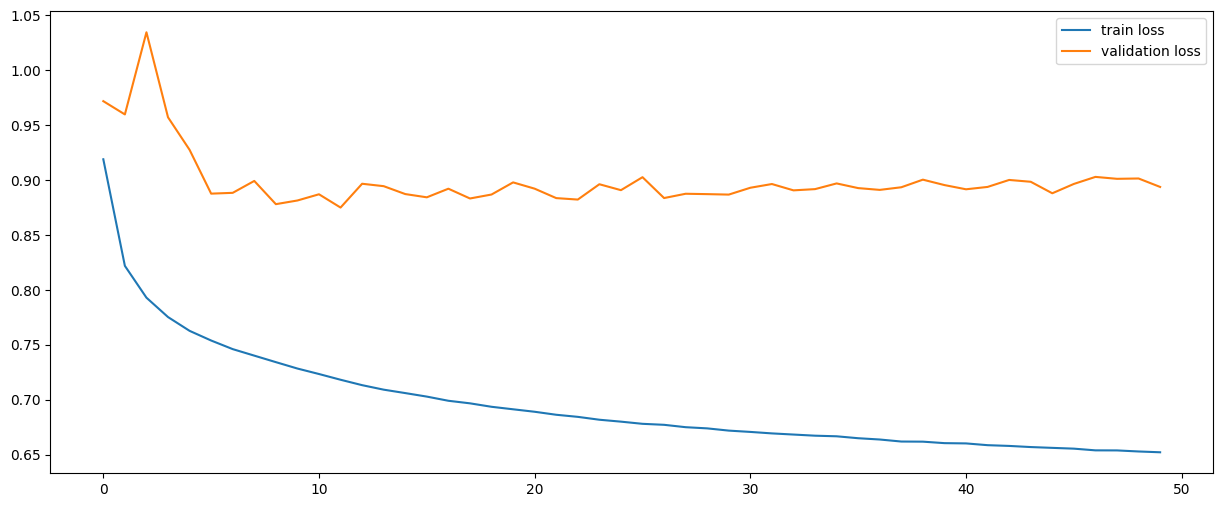

In [18]:
plt.figure(figsize=(15,6))
plt.plot(train_losses, label='train loss')
plt.plot(val_losses, label='validation loss')
plt.legend()

#### Model Testing

In [19]:
model = torch.load('best_val_model_pytorch')

n_correct = 0.
n_total = 0.
for inputs, targets in test_loader:
    # Move to GPU
    inputs, targets = inputs.to(device, dtype=torch.float), targets.to(device, dtype=torch.int64)

    # Forward pass
    outputs = model(inputs)
    
    # Get prediction
    # torch.max returns both max and argmax
    _, predictions = torch.max(outputs, 1)

    # update counts
    n_correct += (predictions == targets).sum().item()
    n_total += targets.shape[0]

test_acc = n_correct / n_total
print(f"Test acc: {test_acc:.4f}")

/var/folders/tk/64xjfsls2nd0mk3dt_4z512h0000gn/T/ipykernel_39698/1217818421.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('best_val_model_pytorch')


Test acc: 0.7334


In [20]:
# model = torch.load('best_val_model_pytorch')
all_targets = []
all_predictions = []

for inputs, targets in test_loader:
    # Move to GPU
    inputs, targets = inputs.to(device, dtype=torch.float), targets.to(device, dtype=torch.int64)

    # Forward pass
    outputs = model(inputs)
    
    # Get prediction
    # torch.max returns both max and argmax
    _, predictions = torch.max(outputs, 1)

    all_targets.append(targets.cpu().numpy())
    all_predictions.append(predictions.cpu().numpy())

all_targets = np.concatenate(all_targets)    
all_predictions = np.concatenate(all_predictions) 

In [21]:
print('accuracy_score:', accuracy_score(all_targets, all_predictions))
print(classification_report(all_targets, all_predictions, digits=4))

accuracy_score: 0.7334035902729984
              precision    recall  f1-score   support

           0     0.6985    0.7663    0.7308     47915
           1     0.8474    0.6757    0.7519     48050
           2     0.6813    0.7610    0.7189     43523

    accuracy                         0.7334    139488
   macro avg     0.7424    0.7343    0.7339    139488
weighted avg     0.7444    0.7334    0.7344    139488

